In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import rank_measure as rm
import pandas as pd
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.models import load_model 
from tensorflow.keras import backend as K

In [2]:
from tensorflow.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : 
    # round : 
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # target set 0(Negative) or 1(Positive)
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # Prediction result set 0(Negative) or 1(Positive)

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) 
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : 
    # round :
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) 
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [16]:
with tf.device('/GPU:0'):
    train_file = np.genfromtxt("./타겟5_세미나비뉴_펀심날짜증가/seminabi_new_v1_train.txt")
    test_file = np.genfromtxt("./타겟5_세미나비뉴_펀심날짜증가/seminabi_new_v1_test.txt")
    now_file  = np.genfromtxt("./타겟5_세미나비뉴_펀심날짜증가/seminabi_new_v1_now.txt")

In [17]:
train_file

array([[6.411e-01, 6.363e-01, 1.000e-04, ..., 6.739e-01, 1.000e+00,
        0.000e+00],
       [6.466e-01, 6.372e-01, 1.000e-04, ..., 6.759e-01, 1.000e+00,
        0.000e+00],
       [5.862e-01, 6.292e-01, 1.000e-04, ..., 6.325e-01, 0.000e+00,
        1.000e+00],
       ...,
       [9.999e-01, 9.999e-01, 1.000e-04, ..., 6.732e-01, 1.000e+00,
        0.000e+00],
       [9.999e-01, 9.999e-01, 1.000e-04, ..., 6.508e-01, 1.000e+00,
        0.000e+00],
       [9.999e-01, 9.999e-01, 1.000e-04, ..., 6.648e-01, 1.000e+00,
        0.000e+00]])

In [18]:
#only indicator feature ex 12 input feature
# cci, rsi, bollinger band, 
print('file loading complete!')
# setting default value
batch_size = 150  # batch size
epochs = 1000
input_size  = 715
target_num = 2

train_x = []
train_y = []
test_x = []
test_y = []
code_arr = []
date_arr = []
vali_x = []
vali_y = []
vali_code_arr = []
vali_date_arr = []

vali_x2 = []
vali_y2 = []
now_x = []
now_y = []
predict_code = []
predict_date = []

scores = []
record_result_info = []
day = []

code_loc = input_size + target_num 
date_loc = code_loc + 1
print(code_loc, date_loc)

for line in train_file:
    x = line[:input_size] #
    y = line[input_size:input_size + target_num]
    train_x.append(x)
    train_y.append(y)

for line in test_file:
    x = line[:input_size]
    y = line[input_size:input_size + target_num]
    code = line[code_loc]
    date = line[date_loc]
    test_x.append(x)
    test_y.append(y)
    code_arr.append(code)
    date_arr.append(date)

for line in now_file:
    x = line[:input_size]
    y = line[input_size:input_size+target_num]
    code = line[code_loc]
    date = line[date_loc]
    vali_x.append(x)
    vali_y.append(y)
    vali_code_arr.append(code)
    vali_date_arr.append(date)
    
train_x = np.array(train_x).reshape(-1, input_size)
test_x = np.array(test_x).reshape(-1, input_size)
vali_x =  np.array(vali_x).reshape(-1, input_size)

train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)
vali_x = pd.DataFrame(vali_x)

train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)
vali_y =  pd.DataFrame(vali_y)

print('train, test date create sucessfully')

file loading complete!
717 718
train, test date create sucessfully


In [19]:
print(len(train_x)) #학습용
print(len(test_x)) #학습 테스트용
print(len(vali_x)) #2개로 나눠서 실제 예측 및 펀심

12339
4411
6596


In [20]:
#vali data is used fundsimulation (펀심용)
vali_len = int(len(vali_x)/2)
vali_x2 = vali_x[:vali_len] #실제 예측 성능 측정
vali_y2= vali_y[:vali_len]
now_x = vali_x[vali_len:] #펀심용
now_y = vali_y[vali_len:]

In [21]:
from tensorflow.keras import optimizers
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)

In [22]:
from tensorflow.keras import regularizers

In [23]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(input_size, activation='softplus', input_shape=(train_x.shape[1],), 
                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5))) # relu 사용 지양
    model.add(Dense(500,  activation='softplus')) 
    model.add(Dropout(0.3))
    model.add(Dense(500,  activation='softplus')) 
    model.add(Dropout(0.3))
    model.add(Dense(500,  activation='softplus')) 
    model.add(Dropout(0.3))
    model.add(Dense(target_num, activation='softplus'))
    model.summary()
    Op = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #Op = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=Op, loss='binary_crossentropy', metrics=['acc', precision, recall, f1score])
    # Fit and evaluate model 
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                        validation_data = (test_x, test_y))
    #history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                        #validation_data = (test_x, test_y), callbacks = es)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 715)               511940    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               358000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)              

Epoch 26/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.9782 - acc: 0.5136 - precision: 0.5209 - recall: 0.3103 - f1score: 0.3878 - val_loss: 0.9014 - val_acc: 0.5235 - val_precision: 0.6982 - val_recall: 0.0822 - val_f1score: 0.1442
Epoch 27/1000
12339/12339 [==============================] - 0s 29us/sample - loss: 0.9679 - acc: 0.5190 - precision: 0.5326 - recall: 0.3273 - f1score: 0.4040 - val_loss: 0.9059 - val_acc: 0.5001 - val_precision: 0.0333 - val_recall: 2.2222e-04 - val_f1score: 4.4150e-04
Epoch 28/1000
12339/12339 [==============================] - 0s 29us/sample - loss: 0.9999 - acc: 0.5094 - precision: 0.5091 - recall: 0.2925 - f1score: 0.3636 - val_loss: 1.5042 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 29/1000
12339/12339 [==============================] - 0s 29us/sample - loss: 1.2152 - acc: 0.5023 - precision: 0.4868 - recall: 0.1789 - f1score: 0.2469 - val_loss: 0.8983 - val_acc

Epoch 57/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.8805 - acc: 0.5535 - precision: 0.5586 - recall: 0.5135 - f1score: 0.5346 - val_loss: 0.8550 - val_acc: 0.6305 - val_precision: 0.6342 - val_recall: 0.6342 - val_f1score: 0.6342
Epoch 58/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.8762 - acc: 0.5611 - precision: 0.5648 - recall: 0.5338 - f1score: 0.5486 - val_loss: 0.8552 - val_acc: 0.6305 - val_precision: 0.6342 - val_recall: 0.6342 - val_f1score: 0.6342
Epoch 59/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.8745 - acc: 0.5586 - precision: 0.5629 - recall: 0.5290 - f1score: 0.5452 - val_loss: 0.8523 - val_acc: 0.6305 - val_precision: 0.6342 - val_recall: 0.6342 - val_f1score: 0.6342
Epoch 60/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.8725 - acc: 0.5582 - precision: 0.5617 - recall: 0.5304 - f1score: 0.5454 - val_loss: 0.8507 - val_acc: 0.6305 - val_preci

12339/12339 [==============================] - 0s 27us/sample - loss: 0.7929 - acc: 0.5863 - precision: 0.5872 - recall: 0.5812 - f1score: 0.5840 - val_loss: 0.7816 - val_acc: 0.6066 - val_precision: 0.5872 - val_recall: 0.7618 - val_f1score: 0.6615
Epoch 89/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.7882 - acc: 0.5901 - precision: 0.5893 - recall: 0.5896 - f1score: 0.5893 - val_loss: 0.7715 - val_acc: 0.6213 - val_precision: 0.6075 - val_recall: 0.7142 - val_f1score: 0.6553
Epoch 90/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.7857 - acc: 0.5864 - precision: 0.5868 - recall: 0.5837 - f1score: 0.5851 - val_loss: 0.7775 - val_acc: 0.6034 - val_precision: 0.5847 - val_recall: 0.7518 - val_f1score: 0.6563
Epoch 91/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.7805 - acc: 0.5919 - precision: 0.5929 - recall: 0.5876 - f1score: 0.5901 - val_loss: 0.7686 - val_acc: 0.6134 - val_precision: 0.5974 -

12339/12339 [==============================] - 0s 28us/sample - loss: 0.7020 - acc: 0.6078 - precision: 0.6069 - recall: 0.6126 - f1score: 0.6096 - val_loss: 0.6955 - val_acc: 0.6158 - val_precision: 0.6040 - val_recall: 0.6948 - val_f1score: 0.6455
Epoch 120/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6999 - acc: 0.6093 - precision: 0.6073 - recall: 0.6150 - f1score: 0.6110 - val_loss: 0.7038 - val_acc: 0.5900 - val_precision: 0.5787 - val_recall: 0.6775 - val_f1score: 0.6238
Epoch 121/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6967 - acc: 0.6114 - precision: 0.6113 - recall: 0.6187 - f1score: 0.6149 - val_loss: 0.7028 - val_acc: 0.5885 - val_precision: 0.5771 - val_recall: 0.6742 - val_f1score: 0.6215
Epoch 122/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6971 - acc: 0.6043 - precision: 0.6032 - recall: 0.6155 - f1score: 0.6092 - val_loss: 0.6889 - val_acc: 0.6221 - val_precision: 0.612

Epoch 150/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6704 - acc: 0.6160 - precision: 0.6129 - recall: 0.6241 - f1score: 0.6184 - val_loss: 0.6857 - val_acc: 0.5807 - val_precision: 0.5708 - val_recall: 0.6571 - val_f1score: 0.6107
Epoch 151/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6709 - acc: 0.6122 - precision: 0.6114 - recall: 0.6205 - f1score: 0.6158 - val_loss: 0.6695 - val_acc: 0.6206 - val_precision: 0.6115 - val_recall: 0.6867 - val_f1score: 0.6463
Epoch 152/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6694 - acc: 0.6137 - precision: 0.6105 - recall: 0.6212 - f1score: 0.6157 - val_loss: 0.6865 - val_acc: 0.5744 - val_precision: 0.5658 - val_recall: 0.6389 - val_f1score: 0.6000
Epoch 153/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6704 - acc: 0.6110 - precision: 0.6098 - recall: 0.6206 - f1score: 0.6151 - val_loss: 0.6723 - val_acc: 0.6103 - val_p

Epoch 181/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6675 - acc: 0.6128 - precision: 0.6110 - recall: 0.6290 - f1score: 0.6197 - val_loss: 0.6692 - val_acc: 0.6128 - val_precision: 0.6031 - val_recall: 0.6733 - val_f1score: 0.6359
Epoch 182/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6621 - acc: 0.6144 - precision: 0.6123 - recall: 0.6248 - f1score: 0.6184 - val_loss: 0.6694 - val_acc: 0.6100 - val_precision: 0.5991 - val_recall: 0.6821 - val_f1score: 0.6374
Epoch 183/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6615 - acc: 0.6201 - precision: 0.6179 - recall: 0.6259 - f1score: 0.6218 - val_loss: 0.6727 - val_acc: 0.6079 - val_precision: 0.5992 - val_recall: 0.6651 - val_f1score: 0.6301
Epoch 184/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6639 - acc: 0.6154 - precision: 0.6140 - recall: 0.6239 - f1score: 0.6189 - val_loss: 0.6741 - val_acc: 0.5976 - val_p

Epoch 212/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6668 - acc: 0.6155 - precision: 0.6092 - recall: 0.6452 - f1score: 0.6266 - val_loss: 0.6833 - val_acc: 0.5758 - val_precision: 0.5626 - val_recall: 0.6862 - val_f1score: 0.6180
Epoch 213/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6647 - acc: 0.6145 - precision: 0.6092 - recall: 0.6398 - f1score: 0.6241 - val_loss: 0.6951 - val_acc: 0.5507 - val_precision: 0.5405 - val_recall: 0.6570 - val_f1score: 0.5929
Epoch 214/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6660 - acc: 0.6131 - precision: 0.6080 - recall: 0.6393 - f1score: 0.6231 - val_loss: 0.6855 - val_acc: 0.5672 - val_precision: 0.5556 - val_recall: 0.6723 - val_f1score: 0.6082
Epoch 215/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6640 - acc: 0.6133 - precision: 0.6083 - recall: 0.6335 - f1score: 0.6206 - val_loss: 0.6820 - val_acc: 0.5771 - val_p

Epoch 243/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6587 - acc: 0.6169 - precision: 0.6124 - recall: 0.6355 - f1score: 0.6237 - val_loss: 0.6756 - val_acc: 0.5981 - val_precision: 0.5898 - val_recall: 0.6565 - val_f1score: 0.6211
Epoch 244/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6587 - acc: 0.6139 - precision: 0.6115 - recall: 0.6295 - f1score: 0.6203 - val_loss: 0.6860 - val_acc: 0.5659 - val_precision: 0.5573 - val_recall: 0.6382 - val_f1score: 0.5949
Epoch 245/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6614 - acc: 0.6105 - precision: 0.6065 - recall: 0.6308 - f1score: 0.6183 - val_loss: 0.6733 - val_acc: 0.6025 - val_precision: 0.5914 - val_recall: 0.6776 - val_f1score: 0.6312
Epoch 246/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6572 - acc: 0.6191 - precision: 0.6152 - recall: 0.6366 - f1score: 0.6256 - val_loss: 0.6860 - val_acc: 0.5718 - val_p

Epoch 274/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6705 - acc: 0.6084 - precision: 0.6014 - recall: 0.6416 - f1score: 0.6206 - val_loss: 0.6794 - val_acc: 0.5859 - val_precision: 0.5713 - val_recall: 0.7037 - val_f1score: 0.6302
Epoch 275/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6678 - acc: 0.6117 - precision: 0.6051 - recall: 0.6455 - f1score: 0.6245 - val_loss: 0.6853 - val_acc: 0.5603 - val_precision: 0.5499 - val_recall: 0.6612 - val_f1score: 0.6003
Epoch 276/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6647 - acc: 0.6094 - precision: 0.6024 - recall: 0.6415 - f1score: 0.6212 - val_loss: 0.6725 - val_acc: 0.6112 - val_precision: 0.5972 - val_recall: 0.7123 - val_f1score: 0.6490
Epoch 277/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6636 - acc: 0.6118 - precision: 0.6052 - recall: 0.6464 - f1score: 0.6250 - val_loss: 0.6806 - val_acc: 0.5769 - val_p

Epoch 305/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6542 - acc: 0.6223 - precision: 0.6183 - recall: 0.6345 - f1score: 0.6262 - val_loss: 0.6868 - val_acc: 0.5708 - val_precision: 0.5633 - val_recall: 0.6356 - val_f1score: 0.5971
Epoch 306/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6822 - acc: 0.5873 - precision: 0.5859 - recall: 0.5978 - f1score: 0.5897 - val_loss: 0.6728 - val_acc: 0.6272 - val_precision: 0.6185 - val_recall: 0.6988 - val_f1score: 0.6554
Epoch 307/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6658 - acc: 0.6117 - precision: 0.6091 - recall: 0.6283 - f1score: 0.6184 - val_loss: 0.6904 - val_acc: 0.5455 - val_precision: 0.5352 - val_recall: 0.6556 - val_f1score: 0.5892
Epoch 308/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6621 - acc: 0.6184 - precision: 0.6098 - recall: 0.6560 - f1score: 0.6320 - val_loss: 0.6815 - val_acc: 0.5782 - val_p

Epoch 336/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6654 - acc: 0.6145 - precision: 0.6064 - recall: 0.6479 - f1score: 0.6263 - val_loss: 0.6895 - val_acc: 0.5702 - val_precision: 0.5572 - val_recall: 0.6934 - val_f1score: 0.6176
Epoch 337/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6695 - acc: 0.6078 - precision: 0.6014 - recall: 0.6393 - f1score: 0.6196 - val_loss: 0.6780 - val_acc: 0.5958 - val_precision: 0.5740 - val_recall: 0.7937 - val_f1score: 0.6647
Epoch 338/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6647 - acc: 0.6122 - precision: 0.6020 - recall: 0.6581 - f1score: 0.6284 - val_loss: 0.6908 - val_acc: 0.5694 - val_precision: 0.5555 - val_recall: 0.6984 - val_f1score: 0.6185
Epoch 339/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6625 - acc: 0.6156 - precision: 0.6099 - recall: 0.6454 - f1score: 0.6271 - val_loss: 0.6794 - val_acc: 0.6009 - val_p

Epoch 367/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6573 - acc: 0.6157 - precision: 0.6125 - recall: 0.6298 - f1score: 0.6209 - val_loss: 0.6801 - val_acc: 0.6100 - val_precision: 0.5972 - val_recall: 0.7007 - val_f1score: 0.6443
Epoch 368/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6538 - acc: 0.6174 - precision: 0.6139 - recall: 0.6352 - f1score: 0.6243 - val_loss: 0.6956 - val_acc: 0.5856 - val_precision: 0.5758 - val_recall: 0.6650 - val_f1score: 0.6168
Epoch 369/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6554 - acc: 0.6204 - precision: 0.6177 - recall: 0.6357 - f1score: 0.6265 - val_loss: 0.6813 - val_acc: 0.5882 - val_precision: 0.5782 - val_recall: 0.6651 - val_f1score: 0.6182
Epoch 370/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6556 - acc: 0.6195 - precision: 0.6154 - recall: 0.6406 - f1score: 0.6277 - val_loss: 0.6858 - val_acc: 0.5855 - val_p

Epoch 398/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6594 - acc: 0.6141 - precision: 0.6101 - recall: 0.6333 - f1score: 0.6214 - val_loss: 0.7001 - val_acc: 0.5517 - val_precision: 0.5408 - val_recall: 0.6686 - val_f1score: 0.5977
Epoch 399/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6585 - acc: 0.6131 - precision: 0.6081 - recall: 0.6351 - f1score: 0.6212 - val_loss: 0.6968 - val_acc: 0.5621 - val_precision: 0.5507 - val_recall: 0.6733 - val_f1score: 0.6057
Epoch 400/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6593 - acc: 0.6146 - precision: 0.6109 - recall: 0.6321 - f1score: 0.6213 - val_loss: 0.6917 - val_acc: 0.6017 - val_precision: 0.5876 - val_recall: 0.6968 - val_f1score: 0.6372
Epoch 401/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6580 - acc: 0.6178 - precision: 0.6128 - recall: 0.6378 - f1score: 0.6250 - val_loss: 0.6962 - val_acc: 0.5647 - val_p

Epoch 429/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6829 - acc: 0.6019 - precision: 0.5939 - recall: 0.6439 - f1score: 0.6178 - val_loss: 0.6969 - val_acc: 0.5703 - val_precision: 0.5527 - val_recall: 0.7462 - val_f1score: 0.6345
Epoch 430/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6807 - acc: 0.6050 - precision: 0.5973 - recall: 0.6461 - f1score: 0.6206 - val_loss: 0.7021 - val_acc: 0.5599 - val_precision: 0.5446 - val_recall: 0.7339 - val_f1score: 0.6248
Epoch 431/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6821 - acc: 0.6059 - precision: 0.5983 - recall: 0.6468 - f1score: 0.6214 - val_loss: 0.7088 - val_acc: 0.5472 - val_precision: 0.5319 - val_recall: 0.7534 - val_f1score: 0.6233
Epoch 432/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6819 - acc: 0.6071 - precision: 0.5990 - recall: 0.6499 - f1score: 0.6232 - val_loss: 0.6970 - val_acc: 0.5718 - val_p

Epoch 460/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6678 - acc: 0.6168 - precision: 0.6115 - recall: 0.6421 - f1score: 0.6263 - val_loss: 0.7021 - val_acc: 0.5824 - val_precision: 0.5659 - val_recall: 0.7212 - val_f1score: 0.6337
Epoch 461/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6700 - acc: 0.6154 - precision: 0.6092 - recall: 0.6447 - f1score: 0.6263 - val_loss: 0.7020 - val_acc: 0.5693 - val_precision: 0.5521 - val_recall: 0.7388 - val_f1score: 0.6316
Epoch 462/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6663 - acc: 0.6166 - precision: 0.6101 - recall: 0.6472 - f1score: 0.6280 - val_loss: 0.7083 - val_acc: 0.5651 - val_precision: 0.5506 - val_recall: 0.7117 - val_f1score: 0.6205
Epoch 463/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6674 - acc: 0.6181 - precision: 0.6123 - recall: 0.6436 - f1score: 0.6274 - val_loss: 0.7043 - val_acc: 0.5635 - val_p

Epoch 491/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6621 - acc: 0.6142 - precision: 0.6097 - recall: 0.6412 - f1score: 0.6249 - val_loss: 0.7032 - val_acc: 0.5662 - val_precision: 0.5533 - val_recall: 0.6953 - val_f1score: 0.6158
Epoch 492/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6594 - acc: 0.6169 - precision: 0.6126 - recall: 0.6368 - f1score: 0.6243 - val_loss: 0.7051 - val_acc: 0.5678 - val_precision: 0.5549 - val_recall: 0.6896 - val_f1score: 0.6146
Epoch 493/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6577 - acc: 0.6174 - precision: 0.6119 - recall: 0.6428 - f1score: 0.6269 - val_loss: 0.7109 - val_acc: 0.5841 - val_precision: 0.5712 - val_recall: 0.6905 - val_f1score: 0.6248
Epoch 494/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6615 - acc: 0.6176 - precision: 0.6130 - recall: 0.6367 - f1score: 0.6245 - val_loss: 0.7007 - val_acc: 0.5738 - val_p

Epoch 522/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6576 - acc: 0.6143 - precision: 0.6096 - recall: 0.6363 - f1score: 0.6225 - val_loss: 0.7117 - val_acc: 0.5801 - val_precision: 0.5690 - val_recall: 0.6724 - val_f1score: 0.6161
Epoch 523/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6543 - acc: 0.6171 - precision: 0.6131 - recall: 0.6366 - f1score: 0.6246 - val_loss: 0.7136 - val_acc: 0.5745 - val_precision: 0.5643 - val_recall: 0.6642 - val_f1score: 0.6099
Epoch 524/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6552 - acc: 0.6160 - precision: 0.6124 - recall: 0.6282 - f1score: 0.6201 - val_loss: 0.7120 - val_acc: 0.5538 - val_precision: 0.5445 - val_recall: 0.6427 - val_f1score: 0.5895
Epoch 525/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6540 - acc: 0.6188 - precision: 0.6155 - recall: 0.6322 - f1score: 0.6237 - val_loss: 0.7183 - val_acc: 0.6046 - val_p

Epoch 553/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6537 - acc: 0.6148 - precision: 0.6094 - recall: 0.6302 - f1score: 0.6195 - val_loss: 0.7119 - val_acc: 0.5706 - val_precision: 0.5637 - val_recall: 0.6280 - val_f1score: 0.5940
Epoch 554/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6507 - acc: 0.6193 - precision: 0.6177 - recall: 0.6336 - f1score: 0.6254 - val_loss: 0.7158 - val_acc: 0.5817 - val_precision: 0.5753 - val_recall: 0.6374 - val_f1score: 0.6046
Epoch 555/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6502 - acc: 0.6191 - precision: 0.6173 - recall: 0.6263 - f1score: 0.6217 - val_loss: 0.7344 - val_acc: 0.5990 - val_precision: 0.5930 - val_recall: 0.6425 - val_f1score: 0.6167
Epoch 556/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6514 - acc: 0.6169 - precision: 0.6136 - recall: 0.6240 - f1score: 0.6187 - val_loss: 0.7129 - val_acc: 0.5824 - val_p

Epoch 584/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6530 - acc: 0.6115 - precision: 0.6081 - recall: 0.6218 - f1score: 0.6147 - val_loss: 0.7556 - val_acc: 0.5981 - val_precision: 0.5933 - val_recall: 0.6328 - val_f1score: 0.6124
Epoch 585/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6477 - acc: 0.6204 - precision: 0.6200 - recall: 0.6301 - f1score: 0.6250 - val_loss: 0.7286 - val_acc: 0.5941 - val_precision: 0.5895 - val_recall: 0.6333 - val_f1score: 0.6105
Epoch 586/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6485 - acc: 0.6186 - precision: 0.6173 - recall: 0.6285 - f1score: 0.6227 - val_loss: 0.7210 - val_acc: 0.5736 - val_precision: 0.5667 - val_recall: 0.6314 - val_f1score: 0.5972
Epoch 587/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6506 - acc: 0.6136 - precision: 0.6114 - recall: 0.6239 - f1score: 0.6175 - val_loss: 0.7051 - val_acc: 0.5798 - val_p

Epoch 615/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6552 - acc: 0.6176 - precision: 0.6079 - recall: 0.6603 - f1score: 0.6329 - val_loss: 0.6998 - val_acc: 0.5787 - val_precision: 0.5694 - val_recall: 0.6565 - val_f1score: 0.6096
Epoch 616/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6504 - acc: 0.6201 - precision: 0.6118 - recall: 0.6582 - f1score: 0.6340 - val_loss: 0.7028 - val_acc: 0.5763 - val_precision: 0.5681 - val_recall: 0.6478 - val_f1score: 0.6052
Epoch 617/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6589 - acc: 0.6097 - precision: 0.6029 - recall: 0.6502 - f1score: 0.6253 - val_loss: 0.6992 - val_acc: 0.6008 - val_precision: 0.5898 - val_recall: 0.6790 - val_f1score: 0.6310
Epoch 618/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6493 - acc: 0.6211 - precision: 0.6149 - recall: 0.6539 - f1score: 0.6337 - val_loss: 0.7290 - val_acc: 0.5703 - val_p

Epoch 646/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6451 - acc: 0.6198 - precision: 0.6151 - recall: 0.6357 - f1score: 0.6252 - val_loss: 0.7395 - val_acc: 0.5909 - val_precision: 0.5852 - val_recall: 0.6358 - val_f1score: 0.6093
Epoch 647/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6456 - acc: 0.6195 - precision: 0.6165 - recall: 0.6315 - f1score: 0.6239 - val_loss: 0.7598 - val_acc: 0.6059 - val_precision: 0.6009 - val_recall: 0.6427 - val_f1score: 0.6210
Epoch 648/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6447 - acc: 0.6220 - precision: 0.6215 - recall: 0.6242 - f1score: 0.6228 - val_loss: 0.7821 - val_acc: 0.6284 - val_precision: 0.6267 - val_recall: 0.6548 - val_f1score: 0.6403
Epoch 649/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6473 - acc: 0.6139 - precision: 0.6121 - recall: 0.6286 - f1score: 0.6202 - val_loss: 0.7121 - val_acc: 0.5957 - val_p

Epoch 677/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6404 - acc: 0.6210 - precision: 0.6199 - recall: 0.6325 - f1score: 0.6260 - val_loss: 0.7704 - val_acc: 0.6109 - val_precision: 0.6075 - val_recall: 0.6399 - val_f1score: 0.6232
Epoch 678/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6392 - acc: 0.6241 - precision: 0.6221 - recall: 0.6310 - f1score: 0.6265 - val_loss: 0.7273 - val_acc: 0.5732 - val_precision: 0.5687 - val_recall: 0.6134 - val_f1score: 0.5901
Epoch 679/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6385 - acc: 0.6237 - precision: 0.6222 - recall: 0.6275 - f1score: 0.6248 - val_loss: 0.7438 - val_acc: 0.5719 - val_precision: 0.5687 - val_recall: 0.6033 - val_f1score: 0.5854
Epoch 680/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6807 - acc: 0.5903 - precision: 0.5899 - recall: 0.5762 - f1score: 0.5787 - val_loss: 0.6992 - val_acc: 0.5875 - val_p

Epoch 708/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6411 - acc: 0.6233 - precision: 0.6212 - recall: 0.6333 - f1score: 0.6271 - val_loss: 0.7615 - val_acc: 0.5856 - val_precision: 0.5801 - val_recall: 0.6324 - val_f1score: 0.6050
Epoch 709/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6407 - acc: 0.6242 - precision: 0.6214 - recall: 0.6312 - f1score: 0.6262 - val_loss: 0.7400 - val_acc: 0.5637 - val_precision: 0.5582 - val_recall: 0.6130 - val_f1score: 0.5841
Epoch 710/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6440 - acc: 0.6208 - precision: 0.6202 - recall: 0.6262 - f1score: 0.6231 - val_loss: 0.7783 - val_acc: 0.6102 - val_precision: 0.6058 - val_recall: 0.6462 - val_f1score: 0.6252
Epoch 711/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6447 - acc: 0.6205 - precision: 0.6176 - recall: 0.6323 - f1score: 0.6248 - val_loss: 0.7401 - val_acc: 0.5204 - val_p

Epoch 739/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6505 - acc: 0.6208 - precision: 0.6143 - recall: 0.6465 - f1score: 0.6297 - val_loss: 0.7283 - val_acc: 0.5577 - val_precision: 0.5494 - val_recall: 0.6355 - val_f1score: 0.5891
Epoch 740/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6460 - acc: 0.6217 - precision: 0.6148 - recall: 0.6528 - f1score: 0.6331 - val_loss: 0.7399 - val_acc: 0.5718 - val_precision: 0.5659 - val_recall: 0.6228 - val_f1score: 0.5929
Epoch 741/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6422 - acc: 0.6243 - precision: 0.6187 - recall: 0.6436 - f1score: 0.6308 - val_loss: 0.7438 - val_acc: 0.5774 - val_precision: 0.5701 - val_recall: 0.6343 - val_f1score: 0.6003
Epoch 742/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6548 - acc: 0.6126 - precision: 0.6085 - recall: 0.6302 - f1score: 0.6185 - val_loss: 0.7275 - val_acc: 0.5884 - val_p

Epoch 770/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6486 - acc: 0.6210 - precision: 0.6153 - recall: 0.6494 - f1score: 0.6318 - val_loss: 0.7511 - val_acc: 0.5864 - val_precision: 0.5774 - val_recall: 0.6533 - val_f1score: 0.6127
Epoch 771/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6503 - acc: 0.6211 - precision: 0.6144 - recall: 0.6477 - f1score: 0.6305 - val_loss: 0.7398 - val_acc: 0.5695 - val_precision: 0.5615 - val_recall: 0.6346 - val_f1score: 0.5956
Epoch 772/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6482 - acc: 0.6246 - precision: 0.6194 - recall: 0.6477 - f1score: 0.6332 - val_loss: 0.7453 - val_acc: 0.5711 - val_precision: 0.5639 - val_recall: 0.6319 - val_f1score: 0.5958
Epoch 773/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6426 - acc: 0.6257 - precision: 0.6205 - recall: 0.6418 - f1score: 0.6309 - val_loss: 0.7454 - val_acc: 0.5540 - val_p

Epoch 801/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6385 - acc: 0.6247 - precision: 0.6222 - recall: 0.6325 - f1score: 0.6273 - val_loss: 0.7362 - val_acc: 0.5594 - val_precision: 0.5543 - val_recall: 0.6043 - val_f1score: 0.5781
Epoch 802/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6777 - acc: 0.6018 - precision: 0.6017 - recall: 0.6018 - f1score: 0.6000 - val_loss: 0.6971 - val_acc: 0.5676 - val_precision: 0.5568 - val_recall: 0.6643 - val_f1score: 0.6055
Epoch 803/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6642 - acc: 0.6221 - precision: 0.6196 - recall: 0.6311 - f1score: 0.6250 - val_loss: 0.6982 - val_acc: 0.5970 - val_precision: 0.5894 - val_recall: 0.6508 - val_f1score: 0.6184
Epoch 804/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6420 - acc: 0.6239 - precision: 0.6137 - recall: 0.6684 - f1score: 0.6398 - val_loss: 0.7606 - val_acc: 0.5783 - val_p

Epoch 832/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6328 - acc: 0.6272 - precision: 0.6264 - recall: 0.6340 - f1score: 0.6301 - val_loss: 0.8740 - val_acc: 0.6076 - val_precision: 0.6043 - val_recall: 0.6351 - val_f1score: 0.6192
Epoch 833/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6384 - acc: 0.6233 - precision: 0.6203 - recall: 0.6353 - f1score: 0.6276 - val_loss: 0.7565 - val_acc: 0.5557 - val_precision: 0.5507 - val_recall: 0.5987 - val_f1score: 0.5736
Epoch 834/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6383 - acc: 0.6229 - precision: 0.6192 - recall: 0.6372 - f1score: 0.6280 - val_loss: 0.7187 - val_acc: 0.5679 - val_precision: 0.5626 - val_recall: 0.6158 - val_f1score: 0.5879
Epoch 835/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6503 - acc: 0.6139 - precision: 0.6110 - recall: 0.6247 - f1score: 0.6177 - val_loss: 0.6866 - val_acc: 0.6092 - val_p

Epoch 863/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6357 - acc: 0.6244 - precision: 0.6211 - recall: 0.6388 - f1score: 0.6298 - val_loss: 0.8065 - val_acc: 0.5911 - val_precision: 0.5860 - val_recall: 0.6278 - val_f1score: 0.6061
Epoch 864/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6386 - acc: 0.6260 - precision: 0.6229 - recall: 0.6341 - f1score: 0.6284 - val_loss: 0.8168 - val_acc: 0.6003 - val_precision: 0.5956 - val_recall: 0.6351 - val_f1score: 0.6146
Epoch 865/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6364 - acc: 0.6253 - precision: 0.6239 - recall: 0.6351 - f1score: 0.6294 - val_loss: 0.7760 - val_acc: 0.5693 - val_precision: 0.5633 - val_recall: 0.6136 - val_f1score: 0.5872
Epoch 866/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6516 - acc: 0.6145 - precision: 0.6146 - recall: 0.6186 - f1score: 0.6164 - val_loss: 0.7220 - val_acc: 0.6149 - val_p

Epoch 894/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6434 - acc: 0.6246 - precision: 0.6169 - recall: 0.6538 - f1score: 0.6347 - val_loss: 0.7357 - val_acc: 0.5355 - val_precision: 0.5300 - val_recall: 0.5982 - val_f1score: 0.5620
Epoch 895/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6556 - acc: 0.6166 - precision: 0.6092 - recall: 0.6522 - f1score: 0.6297 - val_loss: 0.7965 - val_acc: 0.5843 - val_precision: 0.5761 - val_recall: 0.6505 - val_f1score: 0.6109
Epoch 896/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6415 - acc: 0.6267 - precision: 0.6183 - recall: 0.6642 - f1score: 0.6403 - val_loss: 0.8006 - val_acc: 0.5839 - val_precision: 0.5776 - val_recall: 0.6334 - val_f1score: 0.6041
Epoch 897/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6366 - acc: 0.6248 - precision: 0.6175 - recall: 0.6562 - f1score: 0.6362 - val_loss: 0.8234 - val_acc: 0.6000 - val_p

Epoch 925/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6636 - acc: 0.6236 - precision: 0.6159 - recall: 0.6562 - f1score: 0.6353 - val_loss: 0.7382 - val_acc: 0.5510 - val_precision: 0.5408 - val_recall: 0.6547 - val_f1score: 0.5921
Epoch 926/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6664 - acc: 0.6212 - precision: 0.6143 - recall: 0.6531 - f1score: 0.6330 - val_loss: 0.7508 - val_acc: 0.5812 - val_precision: 0.5686 - val_recall: 0.6791 - val_f1score: 0.6187
Epoch 927/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6614 - acc: 0.6247 - precision: 0.6178 - recall: 0.6525 - f1score: 0.6346 - val_loss: 0.7512 - val_acc: 0.5704 - val_precision: 0.5601 - val_recall: 0.6533 - val_f1score: 0.6029
Epoch 928/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6601 - acc: 0.6244 - precision: 0.6170 - recall: 0.6569 - f1score: 0.6362 - val_loss: 0.7514 - val_acc: 0.5558 - val_p

Epoch 956/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6581 - acc: 0.6222 - precision: 0.6153 - recall: 0.6532 - f1score: 0.6336 - val_loss: 0.7452 - val_acc: 0.5644 - val_precision: 0.5560 - val_recall: 0.6302 - val_f1score: 0.5907
Epoch 957/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6532 - acc: 0.6274 - precision: 0.6218 - recall: 0.6529 - f1score: 0.6369 - val_loss: 0.7486 - val_acc: 0.5704 - val_precision: 0.5617 - val_recall: 0.6324 - val_f1score: 0.5949
Epoch 958/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6560 - acc: 0.6221 - precision: 0.6175 - recall: 0.6396 - f1score: 0.6282 - val_loss: 0.7523 - val_acc: 0.5697 - val_precision: 0.5617 - val_recall: 0.6302 - val_f1score: 0.5939
Epoch 959/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6523 - acc: 0.6233 - precision: 0.6174 - recall: 0.6452 - f1score: 0.6309 - val_loss: 0.7705 - val_acc: 0.5830 - val_p

Epoch 987/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6483 - acc: 0.6201 - precision: 0.6142 - recall: 0.6405 - f1score: 0.6270 - val_loss: 0.7752 - val_acc: 0.5973 - val_precision: 0.5901 - val_recall: 0.6411 - val_f1score: 0.6144
Epoch 988/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6467 - acc: 0.6262 - precision: 0.6207 - recall: 0.6489 - f1score: 0.6345 - val_loss: 0.7675 - val_acc: 0.5876 - val_precision: 0.5806 - val_recall: 0.6319 - val_f1score: 0.6050
Epoch 989/1000
12339/12339 [==============================] - 0s 28us/sample - loss: 0.6547 - acc: 0.6147 - precision: 0.6111 - recall: 0.6343 - f1score: 0.6224 - val_loss: 0.7445 - val_acc: 0.6285 - val_precision: 0.6250 - val_recall: 0.6591 - val_f1score: 0.6415
Epoch 990/1000
12339/12339 [==============================] - 0s 27us/sample - loss: 0.6494 - acc: 0.6226 - precision: 0.6197 - recall: 0.6389 - f1score: 0.6291 - val_loss: 0.7677 - val_acc: 0.5779 - val_p

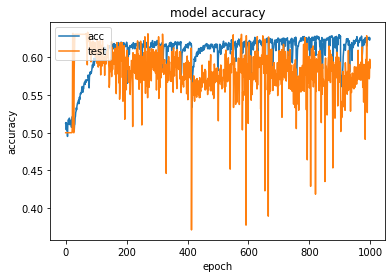

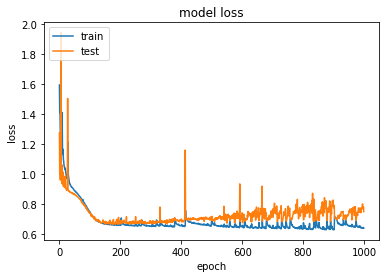

In [24]:
## summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'test'], loc='upper left')
plt.savefig('test.pdf')
plt.show()

## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.pdf')
plt.show()

In [25]:
_loss, _acc, _precision, _recall, _f1score = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print('loss: {:.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, f1score: {:.4f}'.format(_loss, _acc, _precision, _recall, _f1score))

loss: 0.7517, accuracy: 0.5860, precision: 0.5814, recall: 0.6162, f1score: 0.5982


In [14]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='Seminabi_new_img_file.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [15]:
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
import matplotlib.pyplot as plt

y_pred_keras = model.predict(now_x)
print(y_pred_keras)
#ROC (Receiver Operating Characteristic)  AUC (Area Under Curve, 곡선 아래 면적)
score = roc_auc_score(now_y, y_pred_keras) 
print(score)

[[1.0413039  0.01046704]
 [1.0351138  0.01158157]
 [0.6614065  0.3775629 ]
 ...
 [0.4160341  0.59673643]
 [0.4329713  0.58394897]
 [0.38182077 0.6236147 ]]


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [46]:
y_pred_keras

array([[0.661222  , 0.36337608],
       [0.6950156 , 0.27973694],
       [0.5213391 , 0.5149429 ],
       ...,
       [0.25580034, 0.71352184],
       [0.26994973, 0.69884175],
       [0.25179875, 0.71805155]], dtype=float32)

ERROR! Session/line number was not unique in database. History logging moved to new session 188


In [ ]:
"""fprs, tprs, thresholds = metrics.roc_curve(now_y.idxmax(axis=1), y_pred_keras[:,1])
plt.figure()
plt.plot([0,0],[1,1], label='STR',  color='green', linestyle='--')
plt.plot(fprs, tprs, label='ROC', color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()"""

In [ ]:
#For fundsimulation using vali data 
new_funsim = []
new_code = []
new_date = []
new_zero = []
#vali_code_arr.append(code)
#vali_date_arr.append(date)
pred_funsim = model.predict(vali_x)
print(pred_funsim.argmax(axis=1))
for i in range(len(pred_funsim)):
    if pred_funsim[i][0] < pred_funsim[i][1]:
        new_funsim.append(pred_funsim[i][1])
        new_date.append(vali_date_arr[i])
        new_code.append(vali_code_arr[i])
        new_zero.append(0.0)

In [ ]:
funsim_code = pd.DataFrame(new_code, columns=['code'])
funsim_date = pd.DataFrame(new_date, columns=['date'])
funsim_rate = pd.DataFrame(new_funsim, columns=['rate'])
funsim_zero = pd.DataFrame(new_zero, columns=['zero'])
funsim_code = funsim_code.astype(str)
funsim_date = funsim_date.astype(int)
pred_funsimDataframe = pd.concat([funsim_code, funsim_date, funsim_rate, funsim_zero], axis=1)

In [ ]:
pred_funsimDataframe

In [ ]:
pred_funsimDataframe['code'] = pred_funsimDataframe['code'].str.zfill(width=8)
pred_funsimDataframe['code'] = pred_funsimDataframe['code'].str.replace(pat='.0', repl='', regex=False)

pred_funsimDataframe = pred_funsimDataframe.sort_values(by='date')
pred_funsimDataframe.to_csv('./세미나비250예측치/seminabi-예측치_date.txt', sep = ',', index = False)